In [34]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import torch.nn.functional as F
from torchvision.datasets import SVHN
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader
from sklearn.metrics import classification_report


In [35]:
criterion = nn.CrossEntropyLoss()

def train(train_loader,model,accuracies,losses):
	optimizer = optim.Adam(model.parameters(), lr=0.001)
	for i, (images, labels) in enumerate(train_loader):
		# Forward pass
		images=to_device(images)
		labels=to_device(labels)
		outputs = model(images)
		loss = criterion(outputs, labels)
		
		# Backward pass and optimization
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		_, predicted = torch.max(outputs.data, 1)
	acc = (predicted == labels).sum().item() / labels.size(0)
	accuracies.append(acc)
	losses.append(loss.item())
	return loss,acc,accuracies,losses
		
def validate(val_loader,model,val_accuracies,val_losses):
	val_loss = 0.0
	val_acc = 0.0
	with torch.no_grad():
		for images, labels in val_loader:
			images=to_device(images)
			labels=to_device(labels)
			outputs = model(images)
			loss = criterion(outputs, labels)
			val_loss += loss.item()
			
			_, predicted = torch.max(outputs.data, 1)
		total = labels.size(0)
		correct = (predicted == labels).sum().item()
		val_acc += correct / total
		val_accuracies.append(val_acc)
		val_losses.append(loss.item())
		return val_loss,val_acc,val_accuracies,val_losses
	

def to_device(a):
	device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
	a.to(device)
	return a

def evaluate(model,test_loader):
	model.eval()

	with torch.no_grad():
		correct = 0
		total = 0
		y_true = []
		y_pred = []
		for images, labels in test_loader:
			images = to_device(images)
			labels = to_device(labels)
			outputs = model(images)
			_, predicted = torch.max(outputs.data, 1)
			total += labels.size(0)
			correct += (predicted == labels).sum().item()
			predicted=predicted.to('cpu')
			labels=labels.to('cpu')
			y_true.extend(labels)
			y_pred.extend(predicted)

	print('\nTest Accuracy: {}%'.format(100 * correct / total))

	print(classification_report(y_true, y_pred))


In [36]:
import matplotlib.pyplot as plt

num_epochs=10

def plot_loss(losses,val_losses):
	plt.plot(range(num_epochs),
		losses, color='red',
		label='Training Loss',
		marker='o')
	plt.plot(range(num_epochs),
		val_losses,
		color='blue',
		linestyle='--',
		label='Validation Loss',
		marker='x')
	plt.xlabel('Epoch')
	plt.ylabel('Loss')
	plt.title('Training and Validation Loss')
	plt.legend()
	plt.show()

def plot_accuracy(accuracies,val_accuracies):
	plt.plot(range(num_epochs),
		accuracies,
		label='Training Accuracy',
		color='red',
		marker='o')
	plt.plot(range(num_epochs),
		val_accuracies,
		label='Validation Accuracy',
		color='blue',
		linestyle=':',
		marker='x')
	plt.xlabel('Epoch')
	plt.ylabel('Accuracy')
	plt.title('Training and Validation Accuracy')
	plt.legend()
	plt.show()

In [37]:
import torchvision
import torch.nn as nn
import torch.nn.functional as F

class Classifier(nn.Module):
	def __init__(self):
		super().__init__()
		self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
		self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
		self.pool = nn.MaxPool2d(2, 2)
		self.dropout1 = nn.Dropout2d(0.25)
		self.dropout2 = nn.Dropout2d(0.5)
		self.fc1 = nn.Linear(64 * 7 * 7, 128)
		self.fc2 = nn.Linear(128, 10)

	def forward(self, x):
		x2=self.conv1(x)
		x1=F.relu(x2)
		x = self.pool(x1)
		x = self.dropout1(x)
		x = self.pool(F.relu(self.conv2(x)))
		x = self.dropout2(x)
		x = x.view(-1, 64 * 7 * 7)
		x = F.relu(self.fc1(x))
		x = self.fc2(x)
		return x


In [38]:
transform_one_channel = transforms.Compose([
                                transforms.CenterCrop((28, 28)),
                                transforms.Grayscale(num_output_channels=1),                              
                                transforms.ToTensor(),
                                transforms.Normalize([0.5,],[0.5,])
                                ])

In [39]:
test_dataset=SVHN(root="E:/git/Door_number_finding_system/data",split='test', download=True, transform=transform_one_channel)
train_dataset=SVHN(root="E:/git/Door_number_finding_system/data", download=True, transform=transform_one_channel)


Using downloaded and verified file: E:/git/Door_number_finding_system/data\test_32x32.mat
E:/git/Door_number_finding_system/data\test_32x32.mat
Using downloaded and verified file: E:/git/Door_number_finding_system/data\train_32x32.mat
E:/git/Door_number_finding_system/data\train_32x32.mat


In [40]:
model = Classifier()
model=to_device(model)
summary(model, (1, 28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
         Dropout2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
         MaxPool2d-5             [-1, 64, 7, 7]               0
         Dropout2d-6             [-1, 64, 7, 7]               0
            Linear-7                  [-1, 128]         401,536
            Linear-8                   [-1, 10]           1,290
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.43
Params size (MB): 1.61
Estimated Total Size (MB): 2.04
----------------------------------------------------------------


In [41]:
batch_size=100
num_epochs=10


In [42]:
val_percent = 0.2
val_size = int(val_percent * len(train_dataset))
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset,[train_size,val_size])

In [43]:
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,pin_memory=True)
val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=False,pin_memory=True)

In [44]:
losses = []
accuracies = []
val_losses = []
val_accuracies = []


In [45]:
for epoch in range(num_epochs):
	loss,acc,accuracies,losses=train(train_loader,model,accuracies,losses)
	val_loss,val_acc,val_accuracies,val_losses=validate(val_loader,model,val_accuracies,val_losses)
			
	print('Epoch [{}/{}] - Loss:{:.4f}, Validation Loss:{:.4f}, Accuracy:{:.2f}, Validation Accuracy:{:.2f}'.format(
		epoch+1, num_epochs, loss.item(), val_loss/100, acc ,val_acc))

Epoch [1/10] - Loss:0.9680, Validation Loss:1.2638, Accuracy:0.67, Validation Accuracy:0.71
Epoch [2/10] - Loss:0.0750, Validation Loss:1.0080, Accuracy:1.00, Validation Accuracy:0.75
Epoch [3/10] - Loss:0.3587, Validation Loss:0.9008, Accuracy:0.83, Validation Accuracy:0.76
Epoch [4/10] - Loss:0.8645, Validation Loss:0.8150, Accuracy:0.67, Validation Accuracy:0.75
Epoch [5/10] - Loss:0.5730, Validation Loss:0.7793, Accuracy:0.67, Validation Accuracy:0.78
Epoch [6/10] - Loss:0.1835, Validation Loss:0.7633, Accuracy:0.83, Validation Accuracy:0.75
Epoch [7/10] - Loss:0.1998, Validation Loss:0.7420, Accuracy:1.00, Validation Accuracy:0.78
Epoch [8/10] - Loss:0.1246, Validation Loss:0.7199, Accuracy:1.00, Validation Accuracy:0.86
Epoch [9/10] - Loss:0.0190, Validation Loss:0.7005, Accuracy:1.00, Validation Accuracy:0.86
Epoch [10/10] - Loss:0.0876, Validation Loss:0.6891, Accuracy:1.00, Validation Accuracy:0.82


In [46]:
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,pin_memory=True)

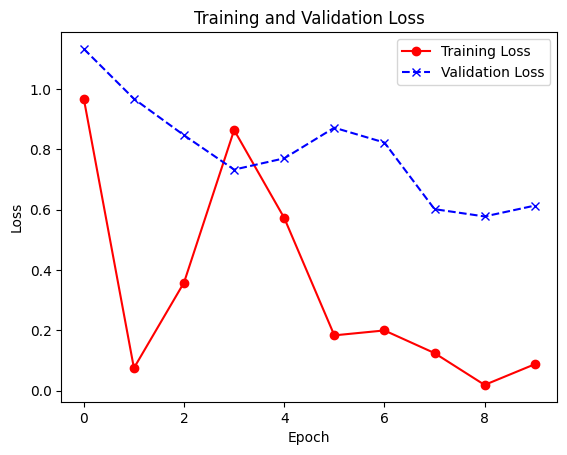

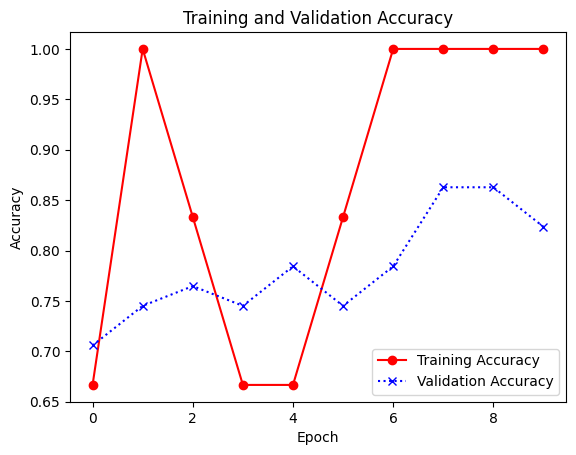

In [47]:
plot_loss(losses,val_losses)
plot_accuracy(accuracies,val_accuracies)


In [48]:
evaluate(model,test_loader)


Test Accuracy: 88.43730792870313%
              precision    recall  f1-score   support

           0       0.92      0.84      0.88      1744
           1       0.94      0.91      0.93      5099
           2       0.89      0.94      0.92      4149
           3       0.86      0.81      0.84      2882
           4       0.88      0.90      0.89      2523
           5       0.89      0.89      0.89      2384
           6       0.87      0.84      0.85      1977
           7       0.88      0.90      0.89      2019
           8       0.79      0.85      0.82      1660
           9       0.82      0.85      0.83      1595

    accuracy                           0.88     26032
   macro avg       0.87      0.87      0.87     26032
weighted avg       0.89      0.88      0.88     26032



In [117]:
from PIL import *
import cv2
import numpy as np

l=[]
def image_loader(image_name):
    transform_one_channel1 = transforms.Compose([
                                transforms.Grayscale(num_output_channels=1),                              
                                transforms.ToTensor(),
                                transforms.Normalize([0.5,],[0.5,])
                                ])
    image = Image.open(image_name)
    '''
     N = 28

# Image shape
    H, W = image.shape[1:3]

# Splitted image shape
    h = (H/N)
    w = (W/N)

    for y in range(N):
        t=[]
        y_start = y * h
        y_end = y_start + h

    # Index must be int!
        y_start = int(y_start)
        y_end = int(y_end)

        for x in range(N):
            x_start = x * w
            x_end = x_start + w

            x_start = int(x_start)
            x_end = int(x_end)

        # Here, save the splitted image
            img = image[:,y_start:y_end,x_start:x_end]
            transform = transforms.ToPILImage()
            img = transform(img)
            img=transform_one_channel(img).float()
            
    image = 
    image = image.unsqueeze(0) 
    print(image)
    tiles = [image[-1,-1,x:x+28,y:y+28] for x in range(0,image.shape[2],28) for y in range(0,image.shape[3],28)]
    print(tiles[2].shape)
    for i in tiles:
        #print(i)
        i=transforms.ToTensor()
        '''
    img=transform_one_channel(image).float()
    output=model(img)
    _, predicted = torch.max(output.data, 1)
    print(predicted)

with torch.no_grad():
    image_loader(r"C:\Users\Sanmitha\Documents\third.jpg") 
    print(*l,sep='\n')

tensor([6])

